In [1]:
import os   
import sys
sys.path.append('..')

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import numpy as np
from tqdm import tqdm

opt = TestOptions().parse(args="""--dataroot /home/sunhwan/work/pdbbind/2018/refined-set \
                   --csvfile /home/sunhwan/work/pdbbind/deep/data/test.csv \
                   --gpu_ids 0 --batch_size 64 --nThreads 16 \
                   --model gnina --grid_method gnina --grid_size 24 --grid_spacing 0.5 \
                   --channels gnina""".split())
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.checkpoints_dir = '../checkpoints'

------------ Options -------------
aspect_ratio: 1.0
batch_size: 64
channels: gnina
checkpoints_dir: ./checkpoints
csvfile: /home/sunhwan/work/pdbbind/deep/data/test.csv
dataroot: /home/sunhwan/work/pdbbind/2018/refined-set
dataset_mode: pdbbind
filter_kd: False
gpu_ids: [0]
grid_method: gnina
grid_size: 24.0
grid_spacing: 0.5
how_many: 50
init_type: normal
input_nc: 6
isTrain: False
max_dataset_size: inf
model: gnina
nThreads: 16
n_layers_D: 3
name: experiment_name
no_dropout: False
norm: instance
ntest: inf
phase: test
results_dir: ./results/
rotate: 90
rvdw: 1.4
serial_batches: False
which_epoch: latest
-------------- End ----------------


In [2]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
model = create_model(opt)

def correlation(Measure, Fit):
    """Calculates the correlation coefficient R^2 between the two sets
       of Y data provided. Logically, in order for the result to have a sense
       you want both Y arrays to have been created from the same X array.""" 
                    
    Mean = np.mean(Measure)
    s1 = 0          
    s2 = 0          
    Size = np.size(Measure) # identical to np.size(Fit)

    for i in range(0, Size):
        s1 += (Measure[i] - Fit[i]) ** 2
        s2 += (Measure[i] - Mean) ** 2
    Rsquare = 1 - s1/s2
    return Rsquare 
                   
# test


CustomDatasetDataLoader
dataset [PdbBindDataset] was created
gnina
initialization method [normal]
---------- Networks initialized -------------
GninaNetworkGenerator(
  (model): Sequential(
    (0): GninaBlock(
      (pool): AdaptiveMaxPool3d(output_size=(24, 24, 24))
      (conv): Conv3d(34, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU(inplace)
    )
    (1): GninaBlock(
      (pool): AdaptiveMaxPool3d(output_size=(12, 12, 12))
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU(inplace)
    )
    (2): GninaBlock(
      (pool): AdaptiveMaxPool3d(output_size=(6, 6, 6))
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU(inplace)
    )
    (3): Flatten()
    (4): Linear(in_features=27648, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               O

In [3]:
# test      
preds = np.zeros(len(dataset))
trues = np.zeros(len(dataset))
with tqdm(total=int(len(dataset)/opt.batch_size)+1) as pbar:
    for i, data in enumerate(dataset):
        if i >= opt.how_many: break
        model.set_input(data)
        model.test()
        offset = i * opt.batch_size
        preds[offset:offset+opt.batch_size] = model.preds.cpu().detach().numpy().flatten()
        trues[offset:offset+opt.batch_size] = data['affinity'].flatten()
        pbar.update()


100%|██████████| 14/14 [00:41<00:00,  1.67it/s]

corr coef: 0.6350110816132369
R2: -0.9371523320756177


In [20]:
print("corr coef:", np.corrcoef(preds, trues)[0,1])
print("R2:", correlation(trues, preds))

corr coef: 0.6350110816132369
R2: 0.36133293576440007


In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Text(0, 0.5, '-Log10(Kd)')

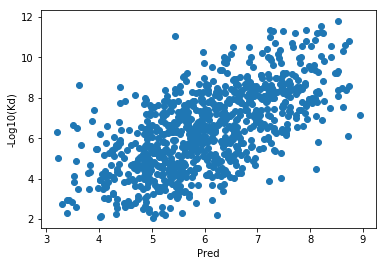

In [21]:
plt.scatter(preds, trues)
plt.xlabel('Pred')
plt.ylabel('-Log10(Kd)')